In [1]:
import pickle

import numpy as np
import pandas as pd

import joblib

from imblearn.over_sampling import SMOTE

import interpret
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression
from interpret.perf import ROC
interpret.set_visualize_provider(interpret.provider.InlineProvider())

# Dataset

In [2]:
with open('../data/all_data.pickle', 'rb') as file:
    all_data = pickle.load(file)

orig_characteristics = all_data['OrigCharacteristics.dta']
orig_characteristics_columns = [
    'type',
    'CutoffLTV',
    'CutoffDSCR',
    'CutoffCpn',
    'log_bal',
    'fixed',
    'buildingage',
    'CutoffOcc',
    'quarter_type',
    'AmortType',
    'Size',
    'OVER_w',
    'past_over',
    'high_overstatement2',
    'Distress',
]
orig_data = orig_characteristics[orig_characteristics_columns]
target_col = 'Distress'
orig_data_with_dummies = pd.get_dummies(
    orig_data,
    columns=[
        'AmortType',
        # 'MSA',
        'type',
        # 'year_priced'
    ]
)
clean_data = orig_data_with_dummies[
    orig_data_with_dummies.notna().all(axis=1)
]

dummy_cols = [col for col, dtype in clean_data.dtypes.items() if dtype == bool]
for dummy_col in dummy_cols:
    clean_data[dummy_col] = clean_data[dummy_col].map({True: 1, False:0})

# Percentage of clean data from whole dataset
print('percentage of clean data and all data ', len(clean_data) / len(orig_data_with_dummies))

y = clean_data[target_col].astype('U32')
X = clean_data.drop(columns=target_col)

sample_size = len(y)
print('sample size ', sample_size)

percentage of clean data and all data  0.6194031714321389
sample size  24804


/var/folders/pr/tf6fbkqx6mv5m13cy7d765fw0000gn/T/ipykernel_17201/2929114164.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data[dummy_col] = clean_data[dummy_col].map({True: 1, False:0})


In [23]:
X['high_overstatement2']

1        1.0
4        1.0
6        0.0
7        0.0
8        0.0
        ... 
40038    1.0
40040    0.0
40041    0.0
40042    1.0
40044    0.0
Name: high_overstatement2, Length: 24804, dtype: float64

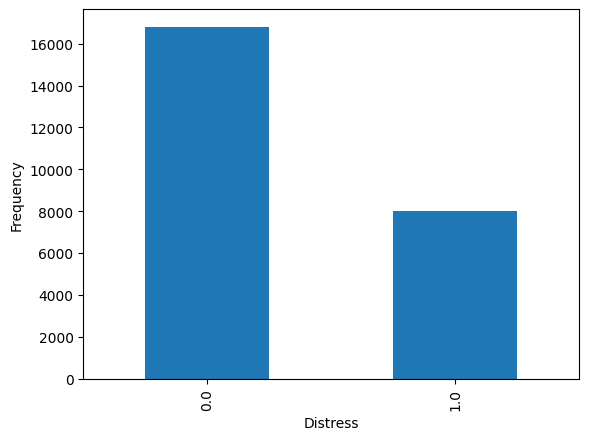

In [3]:
# ax = y.astype('float').plot(kind='hist',title='')
ax = y.value_counts().plot.bar()
ax.set_ylabel('Frequency')
fig = ax.get_figure()
fig.savefig('../plots/Distress_class_imbalance.png',format='png', bbox_inches='tight')


# Explainable Boosting Machine

#### Use EBM parameters that performed with highest ROC whilst training

In [4]:
# load configs that were determined via cross validated hyperparameter tuning
with open('../models/best_params_ebm_maximize.joblib', 'rb') as file:
    ebm_configs = joblib.load(file)['params']

ebm_configs

{'greediness': 0.007,
 'max_bins': 340,
 'inner_bags': 0,
 'outer_bags': 8,
 'max_rounds': 5000,
 'early_stopping_rounds': 40,
 'learning_rate': 0.0009,
 'smoothing_rounds': 4}

In [5]:
ebm = ExplainableBoostingClassifier(**ebm_configs)

In [6]:
X_oversampled, y_oversampled = SMOTE().fit_resample(X, y)

In [7]:
ebm.fit(X_oversampled, y_oversampled)

ExplainableBoostingClassifier(early_stopping_rounds=40, greediness=0.007,
                              learning_rate=0.0009, max_bins=340,
                              smoothing_rounds=4)

In [8]:
interpret.show(ebm.explain_global())

In [9]:
ebm_global = ebm.explain_global()
for idx, feature_name in enumerate(ebm_global.feature_names):
    ebm_global.visualize(idx).write_image(f'../plots/ebm/{feature_name}.png', engine='kaleido')

In [10]:
interpret.show(ROC(ebm).explain_perf(X, y, name='ROC EBM'))

#### Use EBM parameters that performed with lowest ROC whilst training

In [11]:
# load configs that were determined via cross validated hyperparameter tuning
with open('../models/best_params_ebm_minimize.joblib', 'rb') as file:
    ebm_configs_min = joblib.load(file)['params']

ebm_configs_min

{'greediness': 0.009000000000000001,
 'max_bins': 198,
 'inner_bags': 3,
 'outer_bags': 8,
 'max_rounds': 5500,
 'early_stopping_rounds': 40,
 'learning_rate': 0.0013,
 'smoothing_rounds': 0}

In [12]:
ebm_min = ExplainableBoostingClassifier(**ebm_configs_min)

In [13]:
X_oversampled, y_oversampled = SMOTE().fit_resample(X, y)

In [14]:
ebm_min.fit(X_oversampled, y_oversampled)

ExplainableBoostingClassifier(early_stopping_rounds=40,
                              greediness=0.009000000000000001, inner_bags=3,
                              learning_rate=0.0013, max_bins=198,
                              max_rounds=5500)

In [15]:
interpret.show(ebm_min.explain_global())

In [16]:
interpret.show(ROC(ebm_min).explain_perf(X, y, name='ROC EBM'))

# Logistic Regression

#### Use Logistic Regression parameters that performed with highest ROC whilst training

In [17]:
# load configs that were determined via cross validated hyperparameter tuning
with open('../models/best_params_LR_maximize.joblib', 'rb') as file:
    lr_configs = joblib.load(file)['params']

lr_configs

{'penalty': 'l2',
 'C': 0.001,
 'class_weight': None,
 'max_iter': 1500,
 'solver': 'newton-cg'}

In [18]:
X_oversampled, y_oversampled = SMOTE().fit_resample(X, y)

In [19]:
lr_model = LogisticRegression(**lr_configs)
# lr_model.fit(X, y)
lr_model.fit(X_oversampled, y_oversampled)

/Users/janik/Documents/Master/KIT/Semester4/Advanced_Machine_Learning_Projekt/.venv/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge

/Users/janik/Documents/Master/KIT/Semester4/Advanced_Machine_Learning_Projekt/.venv/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge



In [20]:
interpret.show(lr_model.explain_global())


In [21]:
lr_global = lr_model.explain_global()
for idx, feature_name in enumerate(lr_global.feature_names):
    lr_global.visualize(idx).write_image(f'../plots/logistic_regression/{feature_name}.png', engine='kaleido')

FileNotFoundError: [Errno 2] No such file or directory: '../plots/logistic_regression/CutoffLTV.png'

In [ ]:
interpret.show(ROC(lr_model).explain_perf(X, y, name='ROC Logistic Regression (max)'))

#### Use Logistic Regression parameters that performed with lowest ROC whilst training

In [ ]:
# load configs that were determined via cross validated hyperparameter tuning
with open('../models/best_params_LR_minimize.joblib', 'rb') as file:
    lr_configs_min = joblib.load(file)['params']

lr_configs_min

{'penalty': 'l2',
 'C': 1.501,
 'class_weight': None,
 'max_iter': 9500,
 'solver': 'newton-cholesky'}

In [ ]:
X_oversampled, y_oversampled = SMOTE().fit_resample(X, y)

In [ ]:
lr_model_min = LogisticRegression(**lr_configs_min)
lr_model_min.fit(X_oversampled, y_oversampled)

In [ ]:
interpret.show(lr_model_min.explain_global())

In [ ]:
interpret.show(ROC(lr_model_min).explain_perf(X, y, name='ROC Logistic Regression (min)'))